In [6]:
import sys
import tensorflow as tf
import matplotlib.animation
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# change runtime to GPU ...

## § 18.3.	Introduction to OpenAI Gym

In [7]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules: # added ex-post
  %pip install -q -U gym
  %pip install -q -U gym[classic_control,box2d,atari,accept-rom-license]

In [8]:
import gym

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [6]:
# added ex-post: look at the first 5 environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

In [7]:
# added ex-post: shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [8]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [9]:
info

{}

In [10]:
img = env.render()
img.shape # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

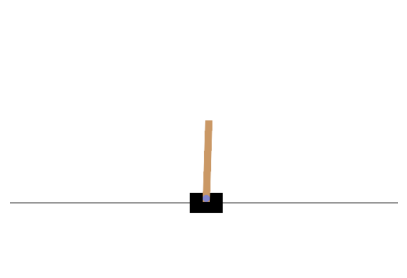

In [11]:
# added ex-post: creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

In [12]:
env.action_space

Discrete(2)

In [13]:
action = 1 # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

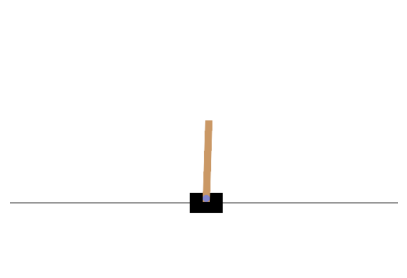

In [14]:
# added ex-post: display the environment
plot_environment(env)
plt.show()

In [15]:
reward

1.0

In [16]:
done

False

In [17]:
truncated

False

In [18]:
info

{}

In [19]:
# added ex-post: reset the environment at the end of an "episode"
if done or truncated:
  obs, info = env.reset()

In [28]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs, info = env.reset(seed=episode)
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    episode_rewards += reward
    if done or truncated:
      break

totals.append(episode_rewards)

In [21]:
import numpy as np

In [22]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(48.0, 0.0, 48.0, 48.0)

In [29]:
# added ex-post: this cell displays an animation of one episode

def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat=False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = matplotlib.animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames=len(frames), repeat=repeat, interval=interval)
  plt.close()
  return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
  frames = []
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  np.random.seed(seed)
  obs, info = env.reset(seed=seed)
  for step in range(n_max_steps):
    frames.append(env.render())
    action = policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
      break
  env.close()
  return plot_animation(frames)

show_one_episode(basic_policy)

## § 18.4.	Neural Network Policies

In [24]:
import tensorflow as tf

In [25]:
tf.random.set_seed(42) # added ex-post: ensures reproducibility on the CPU

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [27]:
# added ex-post: a function that creates an animation for a given policy model

def pg_policy(obs):
  left_proba = model.predict(obs[np.newaxis], verbose=0)
  return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

## § 18.6.	Policy Gradients

In [28]:
def play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    left_proba = model(obs[np.newaxis])
    action = (tf.random.uniform([1, 1]) > left_proba)
    y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
    loss = tf.reduce_mean(loss_fn(y_target, left_proba))

  grads = tape.gradient(loss, model.trainable_variables)
  obs, reward, done, truncated, info = env.step(int(action))
  return obs, reward, done, truncated, grads

In [29]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs, info = env.reset()
    for step in range(n_max_steps):
      obs, reward, done, truncated, grads = play_one_step(
          env, obs, model, loss_fn
      )
      current_rewards.append(reward)
      current_grads.append(grads)
      if done or truncated:
        break

    all_rewards.append(current_rewards)
    all_grads.append(current_grads)

  return all_rewards, all_grads

In [30]:
def discount_rewards(rewards, discount_factor):
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step + 1] * discount_factor
  return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
  all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                            for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean) / reward_std
          for discounted_rewards in all_discounted_rewards]

In [31]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [32]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [33]:
# n_iterations = 150 # modified ex-post: 1x T4 GPU crashes at 140, 120- ...
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [34]:
# added ex-post: create the neural net and reset the environment, for reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

obs, info = env.reset(seed=42)

In [35]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [36]:
for iteration in range(n_iterations):
  all_rewards, all_grads = play_multiple_episodes(
      env, n_episodes_per_update, n_max_steps, model, loss_fn
  )
  # added ex-post: displays some debig info during training
  total_rewards = sum(map(sum, all_rewards))
  print(f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

  all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                     discount_factor)
  all_mean_grads = []
  for var_index in range(len(model.trainable_variables)):
    mean_grads = tf.reduce_mean(
        [final_reward * all_grads[episode_index][step][var_index]
         for episode_index, final_rewards in enumerate(all_final_rewards)
            for step, final_reward in enumerate(final_rewards)],
        axis=0
    )
    all_mean_grads.append(mean_grads)

  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 100/100, mean rewards: 77.4

In [37]:
# added ex-post: displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

In [38]:
# added ex-post: [extra material] Markov Chains
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1], # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1], # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0], # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]] # from s3 to s0, s1, s2, s3

# n_max_steps = 1000 # to avoid blocking in case of an infinite loop
n_max_steps = 200
terminal_states = [3]

def run_chain(start_state):
  current_state = start_state
  for step in range(n_max_steps):
    print(current_state, end=" ")
    if current_state in terminal_states:
      break
    current_state = np.random.choice(
        range(len(transition_probabilities)),
        p=transition_probabilities[current_state]
    )
  else:
    print("...", end="")

  print()

for idx in range(10):
  print(f"Run #{idx + 1}: ", end="")
  run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


## § 18.7.	Markov Decision Processes

In [39]:
transition_probabilities = [ # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [ # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [40]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
  Q_values[state, actions] = 0.0 # for all possible actions

In [42]:
gamma = 0.90 # the discount factor

history1 = [] # added ex-post: needed for the figure below
for iteration in range(50):
  Q_prev = Q_values.copy()
  history1.append(Q_prev) # added ex-post
  for s in range(3):
    for a in possible_actions[s]:
      Q_values[s, a] = np.sum([
          transition_probabilities[s][a][sp]
          * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
        for sp in range(3)
      ])

history1 = np.array(history1) # added ex-post

In [43]:
Q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [44]:
Q_values.argmax(axis=1) # optimal action for each state

array([0, 0, 1])

## § 18.9.	Q-Learning

In [45]:
def step(state, action):
  probas = transition_probabilities[state][action]
  next_state = np.random.choice([0, 1, 2], p=probas)
  reward = rewards[state][action][next_state]
  return next_state, reward

In [46]:
def exploration_policy(state):
  return np.random.choice(possible_actions[state])

In [47]:
# added ex-post: initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
  Q_values[state][actions] = 0

In [48]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []  # added ex-post: needed for the figure below

for iteration in range(10_000):
  history2.append(Q_values.copy()) # added ex-post
  action = exploration_policy(state)
  next_state, reward = step(state, action)
  next_value = Q_values[next_state].max() # greedy policy at the next step
  alpha = alpha0 / (1 + iteration * decay)
  Q_values[state, action] *= 1 - alpha
  Q_values[state, action] += alpha * (reward + gamma + next_value)
  state = next_state

history2 = np.array(history2) # added ex-post

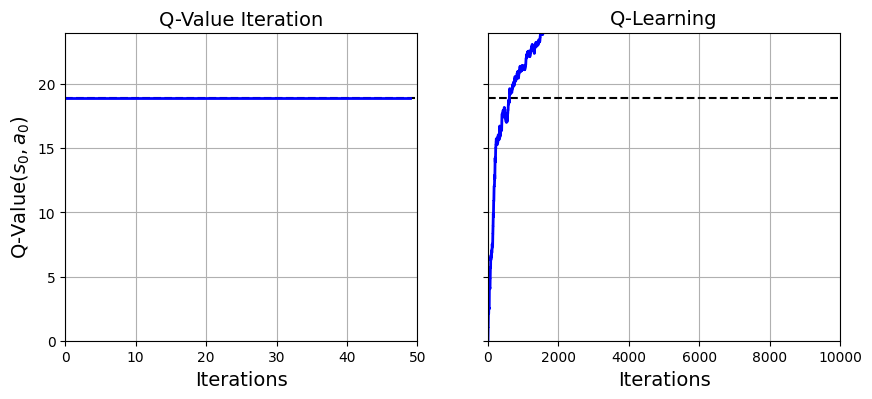

In [49]:
# added ex-post: learning curve of the Q-value vs. Q-learning algorithm

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
  ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
  ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
  ax.set_xlabel("Iterations", fontsize=14)
  ax.axis([0, width, 0, 24])
  ax.grid(True)

plt.show()

## § 18.10.	Implementing Deep Q-Learning

In [6]:
tf.random.set_seed(42)

In [7]:
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [17]:
def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs) # random action
  else:
    Q_values = model.predict(state[np.newaxis], verbose=0)[0]
    return Q_values.argmax() # optimal action according to the DQN

In [12]:
from collections import deque

In [13]:
replay_buffer = deque(maxlen=2000)

In [55]:
# added ex-post: a basic circular buffer implementation

class ReplayBuffer:
  def __init__(self, max_size):
    self.buffer = np.empty(max_size, dtype=object)
    self.max_size = max_size
    self.index = 0
    self.size = 0

  def append(self, obj):
    self.buffer[self.index] = obj
    self.size = min(self.size + 1, self.max_size)
    self.index = (self.index + 1) % self.max_size

  def sample(self, batch_size):
    indices = np.random.randint(self.size, size=batch_size)
    return self.buffer[indices]

In [19]:
def sample_experiences(batch_size):
  indices = np.random.randint(len(replay_buffer), size=batch_size)
  batch = [replay_buffer[index] for index in indices]
  return [
      np.array([experience[field_index] for experience in batch])
      for field_index in range(6)
  ] # [states, actions, rewards, next_states, dones, truncateds]

In [15]:
def play_one_step(env, state, epsilon):
  action = epsilon_greedy_policy(state, epsilon)
  next_state, reward, done, truncated, info = env.step(action)
  replay_buffer.append((state, action, reward, next_state, done, truncated))
  return next_state, reward, done, truncated, info

In [65]:
# added ex-post: for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [66]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones, truncateds = experiences
  next_Q_values = model.predict(next_states, verbose=0)
  max_next_Q_values = next_Q_values.max(axis=1)
  runs = 1.0 - (dones | truncateds) # episode is not done or truncated
  target_Q_values = rewards + runs * discount_factor * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [67]:
for episode in range(600):
  obs, info = env.reset()
  for step in range(200):
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  # added ex-post: displays debug info, stores data for the next figure, and
  #                keeps track of the best model weights so far
  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)

model.set_weights(best_weights)  # added ex-post: restores the best model weights

Episode: 52, Steps: 9, eps: 0.898

Episode: 600, Steps: 141, eps: 0.010

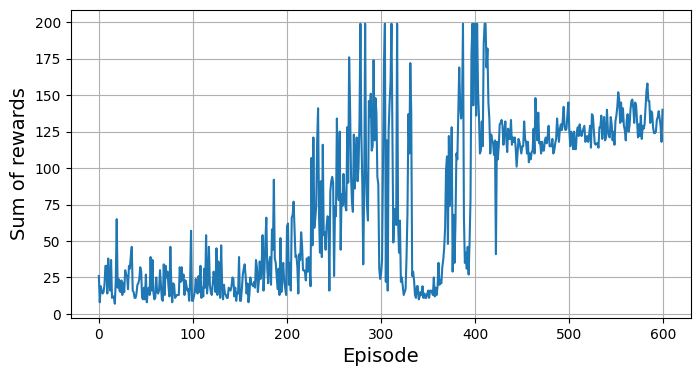

In [68]:
# added ex-post: learning curve of the Deep Q-learning (DQN) algorithm
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [69]:
# added ex-post: shows an animation of the trained DQN playing 1 episode
show_one_episode(epsilon_greedy_policy)

## § 18.11.	Deep Q-Learning Variants

### § 18.11.1.	Fixed Q-value Targets

In [70]:
# added ex-post: create the same DQN model
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [71]:
target = tf.keras.models.clone_model(model) # clone the model's architecture
target.set_weights(model.get_weights()) # copy the weights

In [72]:
# next_Q_values = target.predict(next_states, verbose=0)

In [73]:
# if episode % 50 == 0:
#   target.set_weights(model.get_weights())

In [74]:
# modified ex-post: same code as above except for the lines marked w/ "<= CHANGED"
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000) # resets the replay buffer

def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones, truncateds = experiences
  next_Q_values = target.predict(next_states, verbose=0) # <= CHANGED
  max_next_Q_values = next_Q_values.max(axis=1)
  runs = 1.0 - (dones | truncateds) # episode is not done or truncated
  target_Q_values = rewards + runs * discount_factor * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [75]:
for episode in range(600):
  obs, info = env.reset()
  for step in range(200):
    epsilon = max(1 - episode / 500, 0.01)
    obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  # added ex-post: displays debug info, stores data for the next figure, and
  #                keeps track of the best model weights so far
  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)
    if episode % 50 == 0:                        # <= CHANGED
      target.set_weights(model.get_weights())  # <= CHANGED

  # Alternatively, you can do soft updates at each step:
  # if episode > 50:
  #   training_step(batch_size)
  #   target_weights = target.get_weights()
  #   online_weights = model.get_weights()
  #   for index, online_weight in enumerate(online_weights):
  #     target_weights[index] = (0.99 * target_weights[index]
  #                              + 0.01 * online_weight)
  #     target.set_weights(target_weights)

model.set_weights(best_weights) # added ex-post: restores the best model weights

Episode: 600, Steps: 192, eps: 0.010

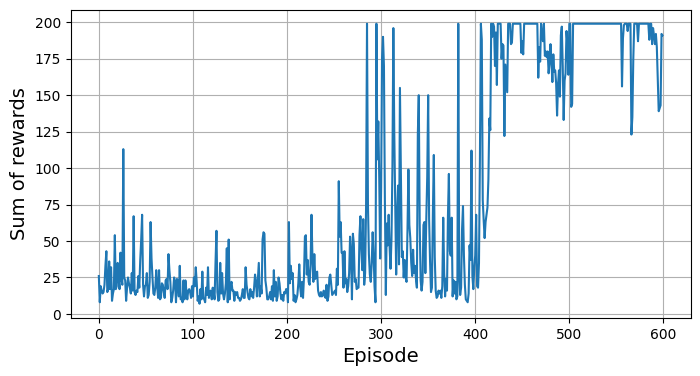

In [76]:
# added ex-post: plot the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [77]:
# added ex-post: shows an animation of the trained DQN playing 1 episode
show_one_episode(epsilon_greedy_policy)

### § 18.11.2.	Double DQN

In [9]:
import numpy as np

In [10]:
# added ex-post: see above
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model) # clone the model's architecture
target.set_weights(model.get_weights()) # copy the weights

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

In [20]:
def training_step(batch_size):
  experiences = sample_experiences(batch_size)
  states, actions, rewards, next_states, dones, truncateds = experiences

  # modified ex-post:
  next_Q_values = model.predict(next_states, verbose=0) # != target.predict()
  best_next_actions = next_Q_values.argmax(axis=1)
  next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
  max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                       ).sum(axis=1)

  # the rest is the same as above:
  runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
  target_Q_values = rewards + runs * discount_factor * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, n_outputs)
  with tf.GradientTape() as tape:
    all_Q_values = model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

# for episode in range(600): # session crashed at episode 589 ...
for episode in range(120):
  obs, info = env.reset()
  for step in range(200):
    # epsilon = max(1 - episode / 500, 0.01)
    epsilon = max(1 - episode / 100, 0.01)
    obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)
    if episode % 50 == 0:
      target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 52, Steps: 10, eps: 0.490

Episode: 120, Steps: 9, eps: 0.010

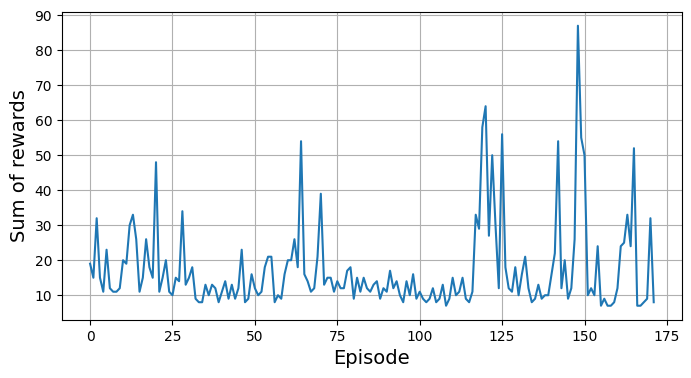

In [21]:
# added ex-post: plot the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [26]:
# added ex-post: shows an animation of the trained DQN playing 1 episode
show_one_episode(epsilon_greedy_policy)

In [27]:
# added ex-post: Dueling Double DQN
tf.random.set_seed(42)

In [28]:
input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [29]:
# added ex-post: train the model

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model) # clone the model's architecture
target.set_weights(model.get_weights()) # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

# for episode in range(600):
for episode in range(120):
  obs, info = env.reset()
  for step in range(200):
    # epsilon = max(1 - episode / 500, 0.01)
    epsilon = max(1 - episode / 100, 0.01)
    obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
    if done or truncated:
      break

  print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
  rewards.append(step)
  if step >= best_score:
    best_weights = model.get_weights()
    best_score = step

  if episode > 50:
    training_step(batch_size)
    if episode % 50 == 0:
      target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 120, Steps: 9, eps: 0.010

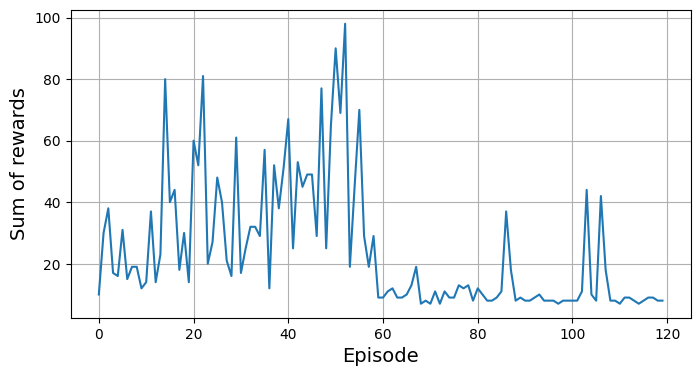

In [30]:
# added ex-post: plot the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [31]:
# added ex-post: shows an animation of the trained DQN playing 1 episode
show_one_episode(epsilon_greedy_policy)

In [32]:
env.close() # added ex-post

## § 18.13.	Exercises

8) Use policy gradients to solve OpenAI Gym's LunarLander-v2 environment.

In [9]:
%pip install swig

In [10]:
%pip install gym[box2d]

In [12]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [13]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [14]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

In [15]:
# source code: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

In [16]:
env.action_space # actions: do nothing, fire left / main / right orientation engine

Discrete(4)

In [17]:
import numpy as np

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="softmax")
])

In [19]:
def lander_play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    probas = model(obs[np.newaxis])
    logits = tf.math.log(probas + tf.keras.backend.epsilon())
    action = tf.random.categorical(logits, num_samples=1)
    loss = tf.reduce_mean(loss_fn(action, probas))
  grads = tape.gradient(loss, model.trainable_variables)
  obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
  return obs, reward, done, truncated, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs, info = env.reset()
    for step in range(n_max_steps):
      obs, reward, done, truncated, grads = lander_play_one_step(
          env, obs, model, loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done or truncated:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)
  return all_rewards, all_grads

In [20]:
def discount_rewards(rewards, discount_factor):
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step + 1] * discount_factor
  return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
  all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                            for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean) / reward_std
          for discounted_rewards in all_discounted_rewards]

In [21]:
# n_iterations = 200 # RAM exhausted at 67 ...
n_iterations = 60
n_episodes_per_update = 16
# n_max_steps = 1000
n_max_steps = 200
discount_factor = 0.99

In [22]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

In [23]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
  all_rewards, all_grads = lander_play_multiple_episodes(
      env, n_episodes_per_update, n_max_steps, model, loss_fn)
  mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
  print(f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean reward: {mean_reward:.1f}  ", end="")
  mean_rewards.append(mean_reward)
  all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
  all_mean_grads = []
  for var_index in range(len(model.trainable_variables)):
    mean_grads = tf.reduce_mean(
        [final_reward * all_grads[episode_index][step][var_index]
        for episode_index, final_rewards in enumerate(all_final_rewards)
          for step, final_reward in enumerate(final_rewards)], axis=0)
    all_mean_grads.append(mean_grads)
  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 1/60, mean reward: -213.7  

Iteration: 60/60, mean reward: 14.5  

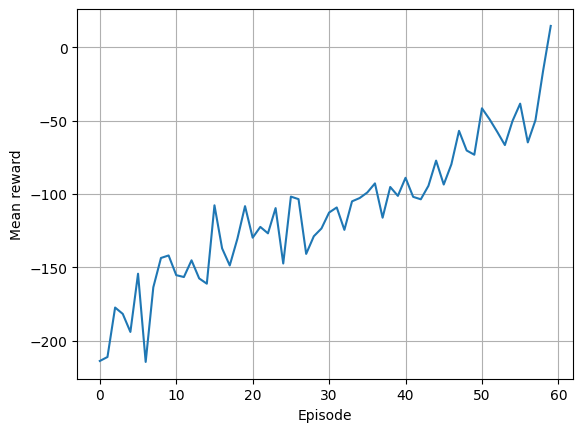

In [24]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [25]:
# def lander_render_policy_net(model, n_max_steps=500, seed=42):
def lander_render_policy_net(model, n_max_steps=200, seed=42):
  frames = []
  env = gym.make("LunarLander-v2", render_mode="rgb_array")
  tf.random.set_seed(seed)
  np.random.seed(seed)
  obs, info = env.reset(seed=seed)
  for step in range(n_max_steps):
    frames.append(env.render())
    probas = model(obs[np.newaxis])
    logits = tf.math.log(probas + tf.keras.backend.epsilon())
    action = tf.random.categorical(logits, num_samples=1)
    obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
    if done or truncated:
      break
  env.close()
  return frames

In [30]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

9) Use a Double Dueling DQN to train an agent that can achieve a superhuman level at the famous Atari Breakout game (`"ALE/Breakout-v5"`). The observations are images. To simplify the task, you should convert them to grayscale (i.e., average over the channels axis), crop them and downsample them, so they're just large enough to play, but not much more. An individual image does not tell you which way the ball and the paddles are going, so you should merge two or three consecutive images to form each state. Lastly, the DQN should be composed mostly of convolutional layers.

In [31]:
# link: https://paperswithcode.com/task/atari-games

In [32]:
env = gym.make("ALE/Breakout-v5")

In [33]:
print(gym.make("ALE/Breakout-v5"))

<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Breakout-v5>>>>


In [34]:
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."] # now we're talking ...

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

10) If you have about $100 to spare, you can purchase a Raspberry Pi 3 plus some cheap robotics components, install TensorFlow on the Pi, and go wild! For ex., check out this [fun post](https://homl.info/2) by Lukas Biewald, or take a look at GoPiGo or BrickPi. Start with simple goals, like making the robot turn around to find the brightest angle (if it has a light sensor) or the closest object (if it has a sonar sensor), and move in that direction. Then you can start using Deep Learning: for example, if the robot has a camera, you can try to implement an object detection algorithm so it detects people and moves toward them. You can also try to use RL to make the agent learn on its own how to use the motors to achieve that goal. Have fun!

In [ ]:
# Once Optimus gets open-sourced ...